<a href="https://colab.research.google.com/github/natkor18/Data_Science_yandex_project/blob/main/forecasting_taxi_orders/forecasting_taxi_orders_on_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.stattools import adfuller

In [ ]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Датасет загрузили в таблицу, преобразовав первый столбец - даты в индексы. Посмотрим что там. Построим график.

In [ ]:
data.head(30)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
data.isna().sum()

num_orders    0
dtype: int64

In [ ]:
print("Самая ранняя дата", data.index.min())
print("Самая поздняя дата", data.index.max())

Самая ранняя дата 2018-03-01 00:00:00
Самая поздняя дата 2018-08-31 23:50:00


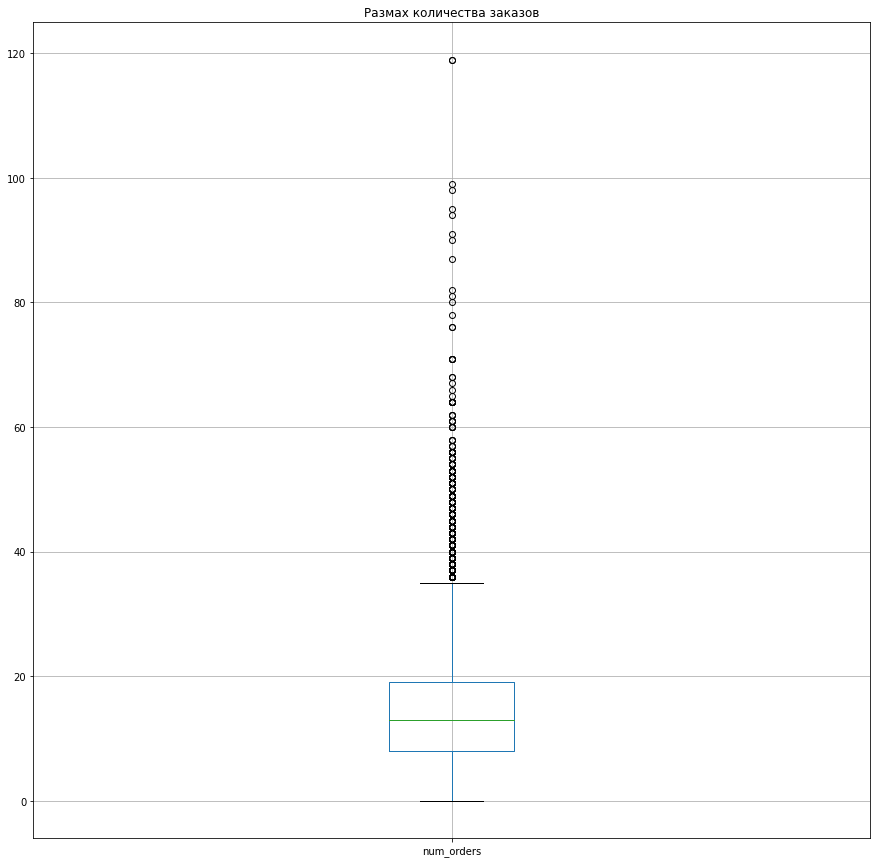

In [ ]:
data.plot(kind='box', title='Размах количества заказов', figsize=(15,15), grid=True);

Если посмотреть на даты, то эти заказы приходятся в основном на август. В августе наблюдается значительный рост. Вероятно, связанный с окончанием отпусков. Так как это временной ряд, то наверное удалить эти значения будет неверно.


In [ ]:
len(data.loc[data['num_orders']>40])

367

In [ ]:
data.query('num_orders>60')

,num_orders
datetime,
2018-04-24 00:30:00,68
2018-07-16 04:40:00,64
2018-07-19 10:50:00,61
2018-08-08 00:50:00,64
2018-08-08 01:00:00,64
2018-08-11 00:50:00,64
2018-08-11 01:00:00,62
2018-08-13 01:00:00,64
2018-08-13 01:10:00,71


Итак. Таблица содержит 26496 записей - данные о заказах такси с интервалом в 10 минут. Пропусков нет. Используя  при считывании index_col=[0], parse_dates=[0] сократим количество выполненных действий.  Построим график по исходным данных, чтобы иметь наглядное представление об исходных данных.

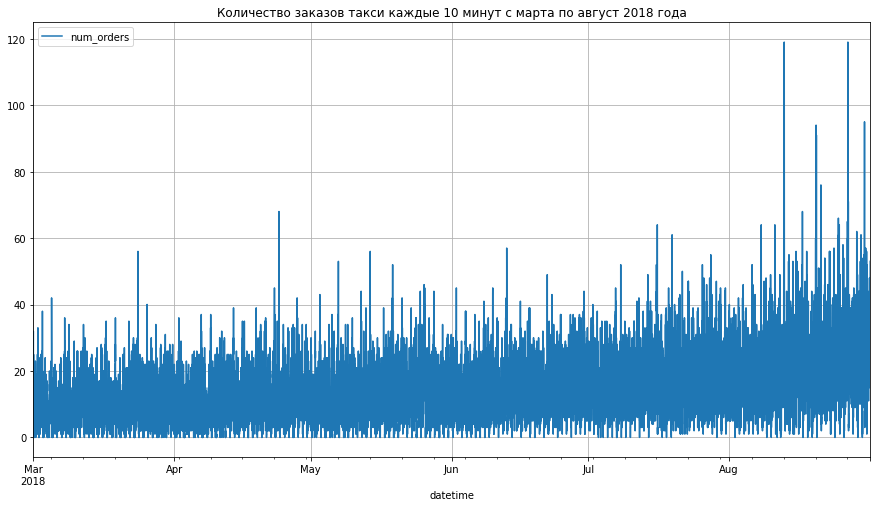

In [ ]:
data.plot(figsize=(15,8), ax=plt.gca(), grid=True)
plt.title("Количество заказов такси каждые 10 минут с марта по август 2018 года");

Cделаем ресепмл по часам, взяв в качестве функции - сумму, так как исходные данные - интервалы по 10 минут.

In [ ]:
data_hour = data.resample('1H').sum()

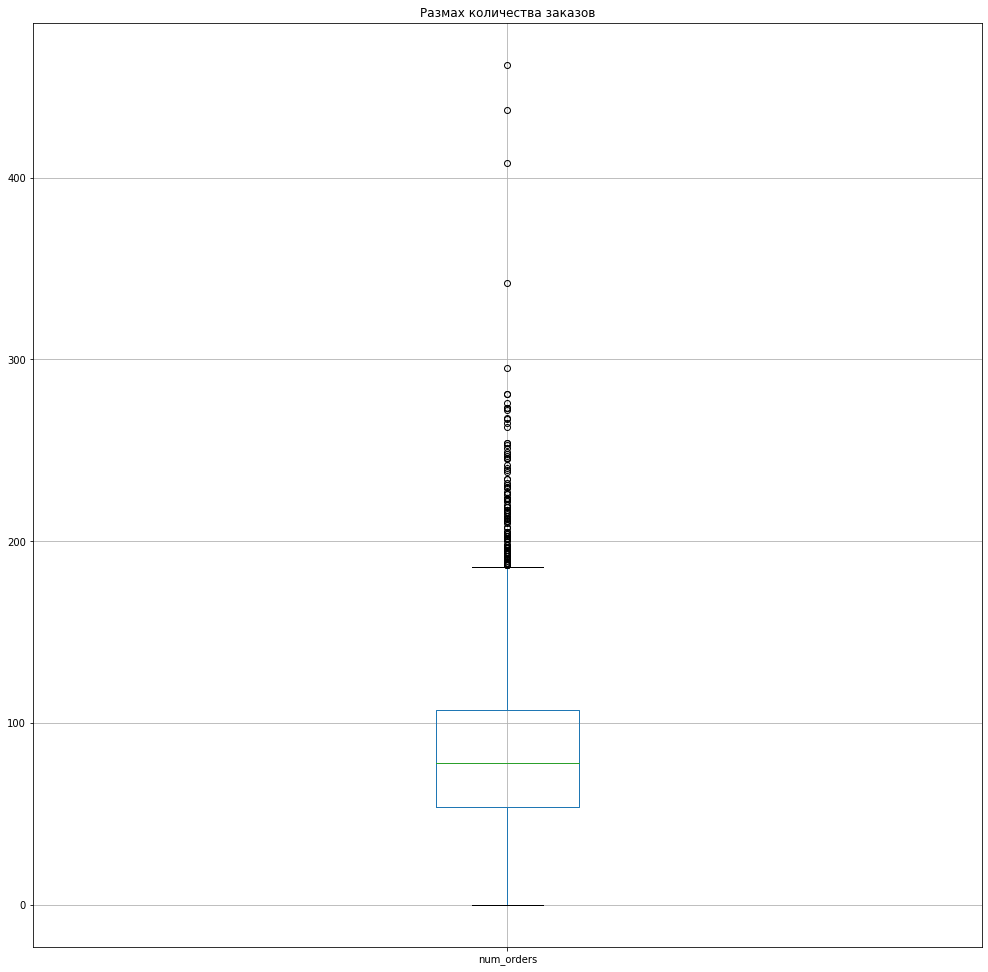

In [ ]:
data_hour['num_orders'].plot(kind='box', title='Размах количества заказов', figsize=(17,17), grid=True);

In [ ]:
data_hour.query('num_orders>230')

,num_orders
datetime,
2018-04-24 00:00:00,253
2018-05-19 00:00:00,234
2018-07-19 10:00:00,251
2018-07-23 00:00:00,245
2018-08-06 00:00:00,248
2018-08-11 00:00:00,249
2018-08-13 01:00:00,273
2018-08-13 02:00:00,437
2018-08-14 01:00:00,231


In [ ]:
data_hour['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

Количество заказов в день в среднем колеблется от 54 до 107.

In [ ]:
data_hour.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Посмотрим как изменится график. Возможно это уже относится к анализу, но хочется сразу посмотреть, как изменилось представление.

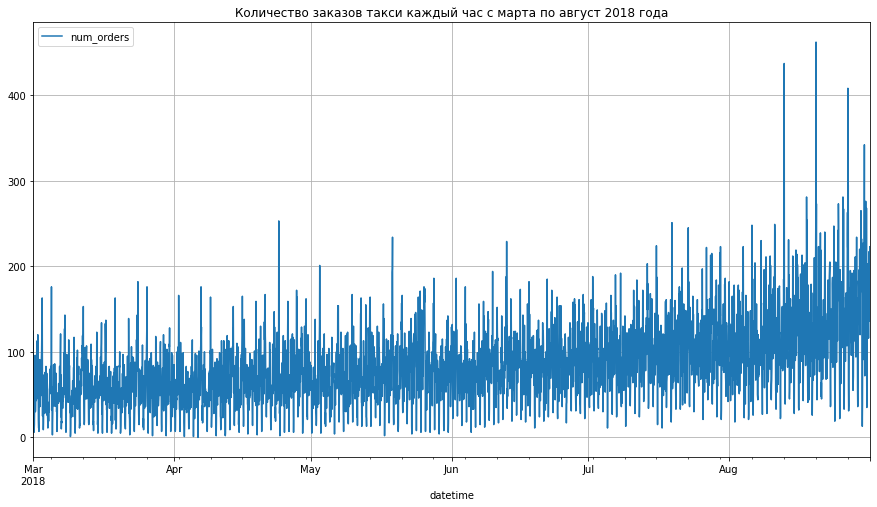

In [ ]:
data_hour.plot(figsize=(15,8), ax=plt.gca(), grid=True)
plt.title("Количество заказов такси каждый час с марта по август 2018 года");

И конечно же, сразу напрашиется вопрос, а как изменяются данные по дням. Посмотрю сразу, потом, при анализе еще раз обратимся к подобных графикам

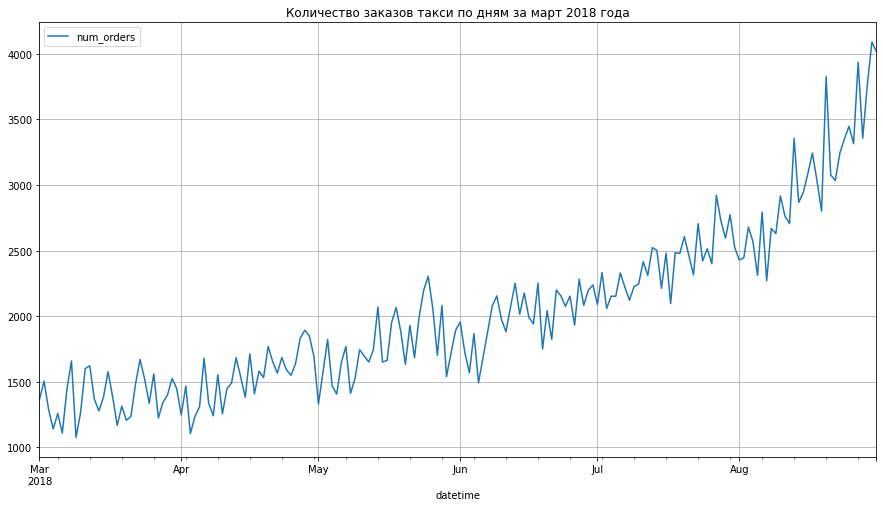

In [ ]:
data.resample('1D').sum().plot(figsize=(15,8), ax=plt.gca(), grid=True)
plt.title("Количество заказов такси по дням за март 2018 года");

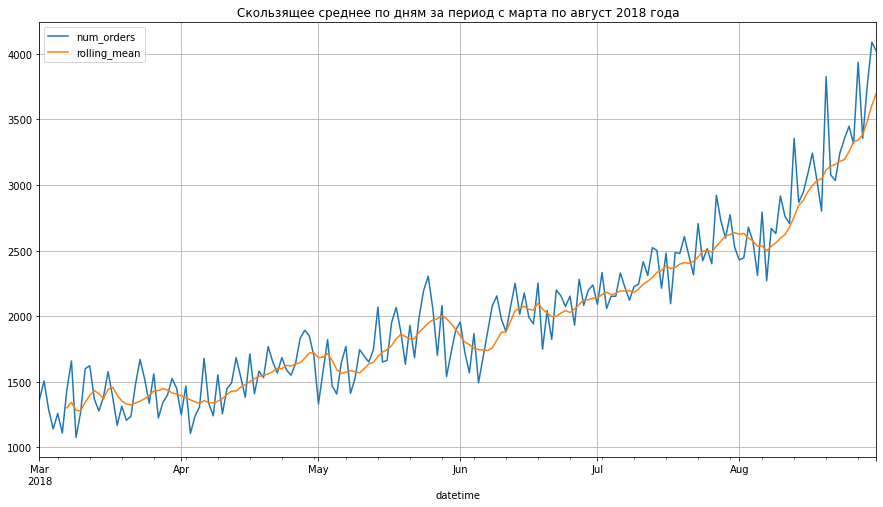

In [ ]:
data_days = data.resample('1D').sum()
data_days['rolling_mean']=data_days.rolling(7).mean()
data_days.plot(figsize=(15,8), ax=plt.gca(), grid=True);
plt.title("Скользящее среднее по дням за период с марта по август 2018 года");

Уже можно говорить об увеличении заказов в летний период. В анализе еще посмотрим на тренд, сезонность и шум.

Подготовим данные для дальнейшего использования - анализа, обучения и предсказания. Получим следующие признаки из имеющихся данных.

1. Календарные
2. Отстающие значения
3. Скользящее среднее

 **Вывод.**
Исходные данные содержали 26496 записей  о заказах такси с интервалом в 10 минут. Данные за период с марта по август 2018 года.
- Самая ранняя дата 2018-03-01 00:00:00
- Самая поздняя дата 2018-08-31 23:50:00

Пропусков нет. По данным наблюдается рост количества заказов к лету.

- проведен ресемпл с частотой в 1 час

Проведем анализ временного ряда, затем создадим новые признаки:
    - Календарные
    - Отстающие значения
    - Скользящее среднее
    
Новый датафрейм с частотой заказов такси в 1 час готов, содержит 4416 записи. Проведем анализ данных, который позволит сделать предварительный прогноз, оценить существующее состояние дел.


## Анализ

Построим несколько графиков, отражающих количество заказов такси по разным интервалам времени. Это позволит нам увидеть картину в разных приближениях.

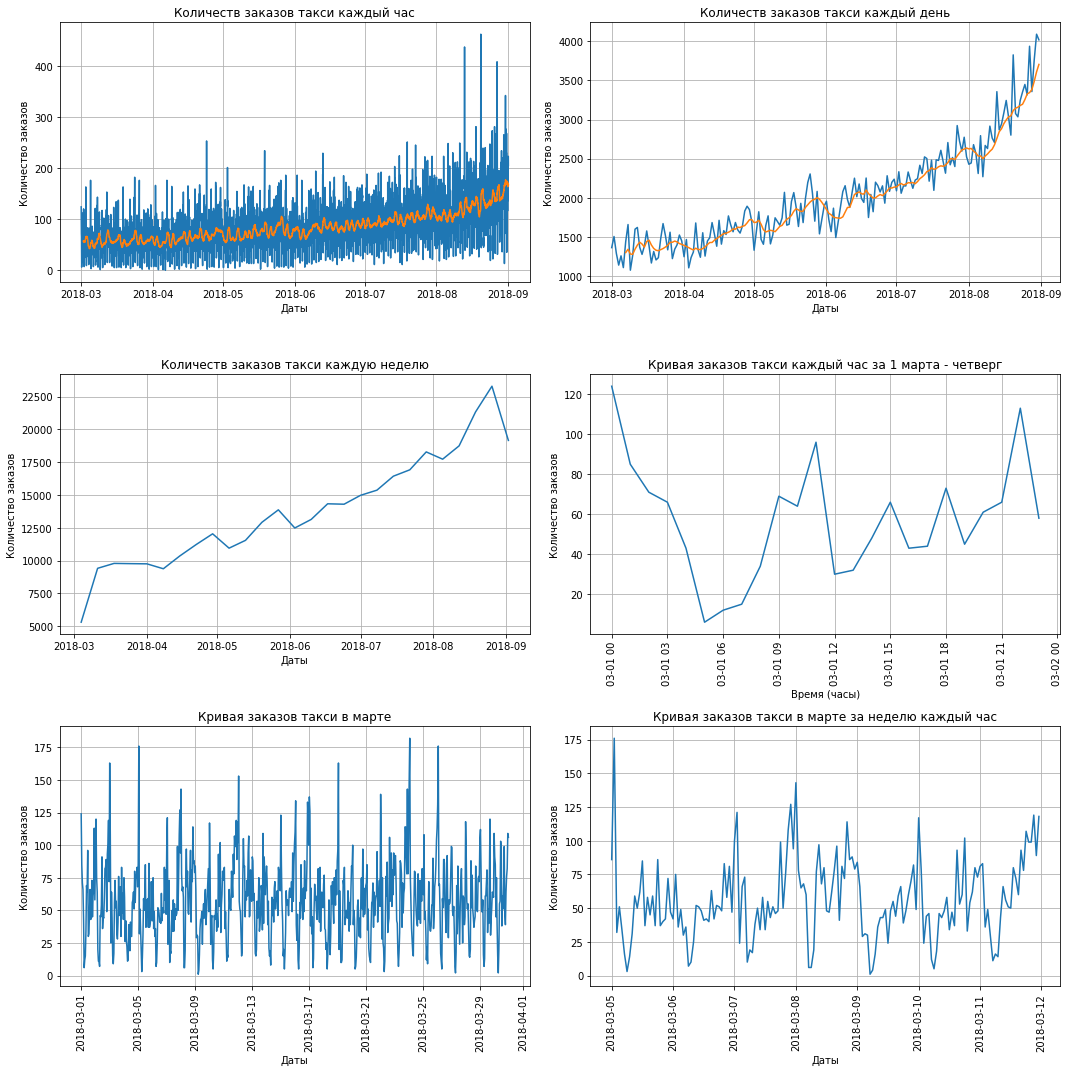

In [ ]:
figure, axis = plt.subplots(3, 2, figsize=(15, 15))

axis[0,0].plot(data_hour['num_orders']);
axis[0,0].plot(data_hour.rolling(24).mean()['num_orders'])
axis[0,0].set_title("Количеств заказов такси каждый час")
axis[0,0].set_ylabel('Количество заказов')
axis[0,0].set_xlabel('Даты')
axis[0,0].grid(True)

axis[0,1].plot(data_hour.resample('1D').sum()['num_orders']);
axis[0,1].plot(data_hour.resample('1D').sum().rolling(7).mean()['num_orders'])
axis[0,1].set_title("Количеств заказов такси каждый день")
axis[0,1].set_ylabel('Количество заказов')
axis[0,1].set_xlabel('Даты')
axis[0,1].grid(True)

axis[1,0].plot(data_hour.resample('1W').sum()['num_orders'])
axis[1,0].set_title("Количеств заказов такси каждую неделю")
axis[1,0].set_ylabel('Количество заказов')
axis[1,0].set_xlabel('Даты')
axis[1,0].grid(True)


axis[1,1].plot(data_hour.loc['2018-03-01']['num_orders']);
axis[1,1].set_title("Кривая заказов такси каждый час за 1 марта - четверг")
axis[1,1].tick_params(axis='x', rotation=90)
axis[1,1].set_ylabel('Количество заказов')
axis[1,1].set_xlabel('Время (часы)')
axis[1,1].grid(True)


axis[2,0].plot(data_hour['2018-03-01':'2018-03-30'].index, data_hour['2018-03-01':'2018-03-30']['num_orders']);
axis[2,0].tick_params(axis='x', rotation=90)
axis[2,0].set_title("Кривая заказов такси в марте")
axis[2,0].set_ylabel('Количество заказов')
axis[2,0].set_xlabel('Даты')
axis[2,0].grid(True)

axis[2,1].plot(data_hour['2018-03-05':'2018-03-11']['num_orders']);
axis[2,1].set_title("Кривая заказов такси в марте за неделю каждый час");
axis[2,1].tick_params(axis='x', rotation=90)
axis[2,1].set_xlabel('Даты')
axis[2,1].set_ylabel('Количество заказов')
axis[2,1].grid(True)
plt.tight_layout()

Что видно из первых графиков. Есть тенденция роста заказов такси к лету. У нас есть данные с марта по август. К сожалению, не располагаем данными за несколько лет, поэтому, сказать о том что это сезонность можно только условно. Возможно к осени количество заказов снижается. Это неизвестно.

Тем не менее. Пока наблюдается рост и даже если осенью и будет снижение, оно все равно не сопоставимо с количеством заказов в марте, их все равно будет больше. Если посмотреть на последнюю неделю, то видим снижение количества заказов. Как дальше поведет себя кривая, тоже неизвсетно.


Кривая заказа по неделям в марте (можно сравнить еще нескоько месяцев) похожа на стохастическую кривую. Рассмотрим такой график подробнее позже.

Тоже сравним количество заказов за несколько дней. Из третьего графика напрашивается предположение, что количество заказов в утренние часы меньше (провал в 5 часов), затем начинает расти. Пик приходится на 11-12 часов - не знаю куда можно ехать в это время, может на работу, 21 час - люди возвращаются с работы или едут отдыхать, 0 часов - возвращаются домой с каких-то мероприятий. Но это всего лишь один день - говорить о том, что это закономерность - рано. Пока предварительно.

Это время расходится с часом-пик на дорогах. Предположу, что заказывают такси в эти часы, понимая что риск попасть в пробку не высок. В другое время лучше ехать на метро.

Последний график подтверждает такую тенденцию - есть провалы - и есть пики. То есть в течение дня точно есть часы наибольшей загруженности, предположительно 11-12, 21, 0 и наименьшей загруженностью - утренние часы - 5 часов, с 00.00 начинается спад, провалы -  12-13, 16-17, 17. Заказов поменьше. По графику за неделю можно сделать вывод о том, что меньше заказов к утру, а в течение дня имеем тенденцию роста.

Также надо проверить будние и выходные дни, праздники. Определить совпадающие пики по дням, особенности в праздники и будни.

Посмотрим, что с трендами и сезонностью.

Не обратила внимание на то, что речь идет о заказах такси в аэропортах. Это важно.

Таким образом, раз пик заказов приходится на понедельник и пятницу - скорее всего это связано с выходными, когда люди улетают на отдых и возвращаются. Тогда вполне логично меньшее количество заказов по вторникам.

In [ ]:
data_hour.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Сделаем ресемпл по дням и посмотрим тренд и сезонность.

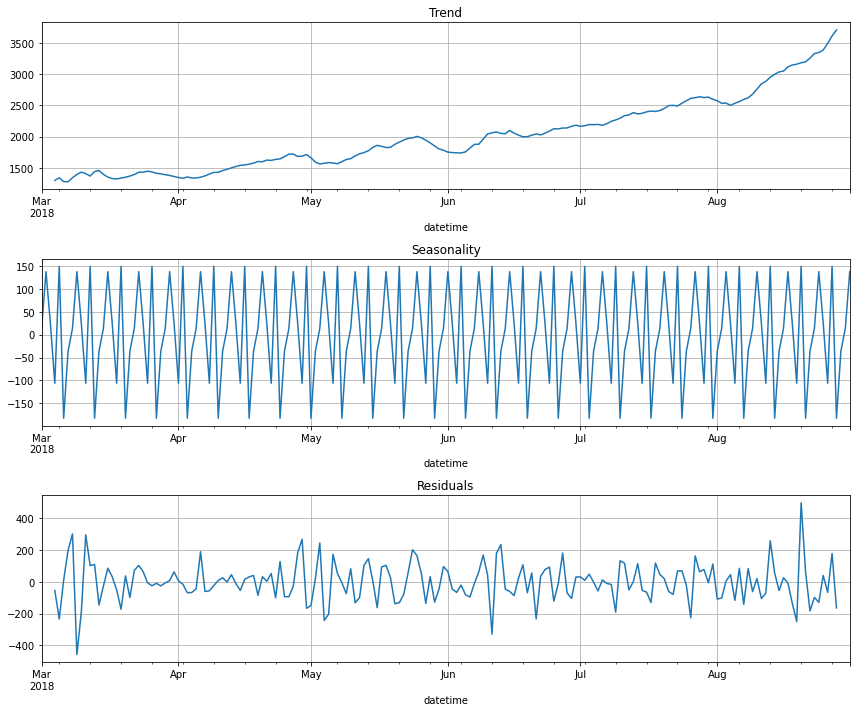

In [ ]:
decomposed = seasonal_decompose(data_hour.resample('1D').sum()['num_orders'])

plt.figure(figsize=(12, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), grid=True)
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), grid=True)
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), grid=True)
plt.title('Residuals')
plt.tight_layout()

Первоначальные предположения подтвердились, тренд такой, что  к лету количество заказов растет. Сезонность - период меньше месяца - посмотрим позже. Остатки - похоже на шум.  Посмотрим еще на меньших временных интервалах.


Сезонная составляющая в первой половине марта и первой половине августа.<br/>


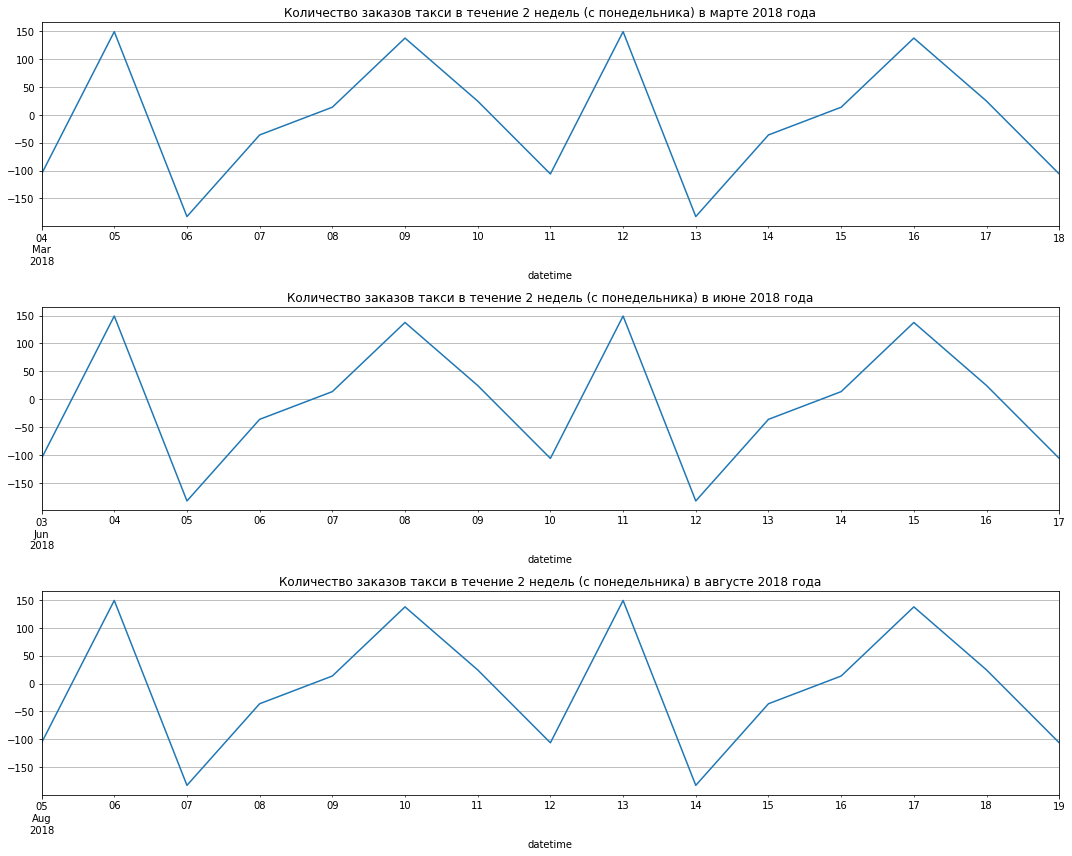

In [ ]:
plt.figure(figsize=(15, 12))

plt.subplot(311)
decomposed.seasonal['2018-03-04':'2018-03-18'].plot(ax=plt.gca(),grid=True);
plt.title('Количество заказов такси в течение 2 недель (с понедельника) в марте 2018 года');

plt.subplot(312)
decomposed.seasonal['2018-06-03':'2018-06-17'].plot(ax=plt.gca(),grid=True);
plt.title('Количество заказов такси в течение 2 недель (с понедельника) в июне 2018 года');


plt.subplot(313)
decomposed.seasonal['2018-08-05':'2018-08-19'].plot(ax=plt.gca(),grid=True);
plt.title('Количество заказов такси в течение 2 недель (с понедельника) в августе 2018 года');

plt.tight_layout()

Пик заказов приходится на понедельник, пятницу. Во вторник и в воскресенье заказов меньше всего. В воскресенье люди готовятся к новой рабочей неделе. А во вторник, середина недели, поэтому пассажиров меньше.

Получили три идентичных графика с периодом в две недели в разное время - март, июнь, август. Можно сделать вывод, что больше заказов в понедельник и пятницу. Меньше всего заказов во вторник и воскресенье. Причем во вторник меньше чем в воскресенье. Со вторника по пятницу количество заказов постепенно нарастает.

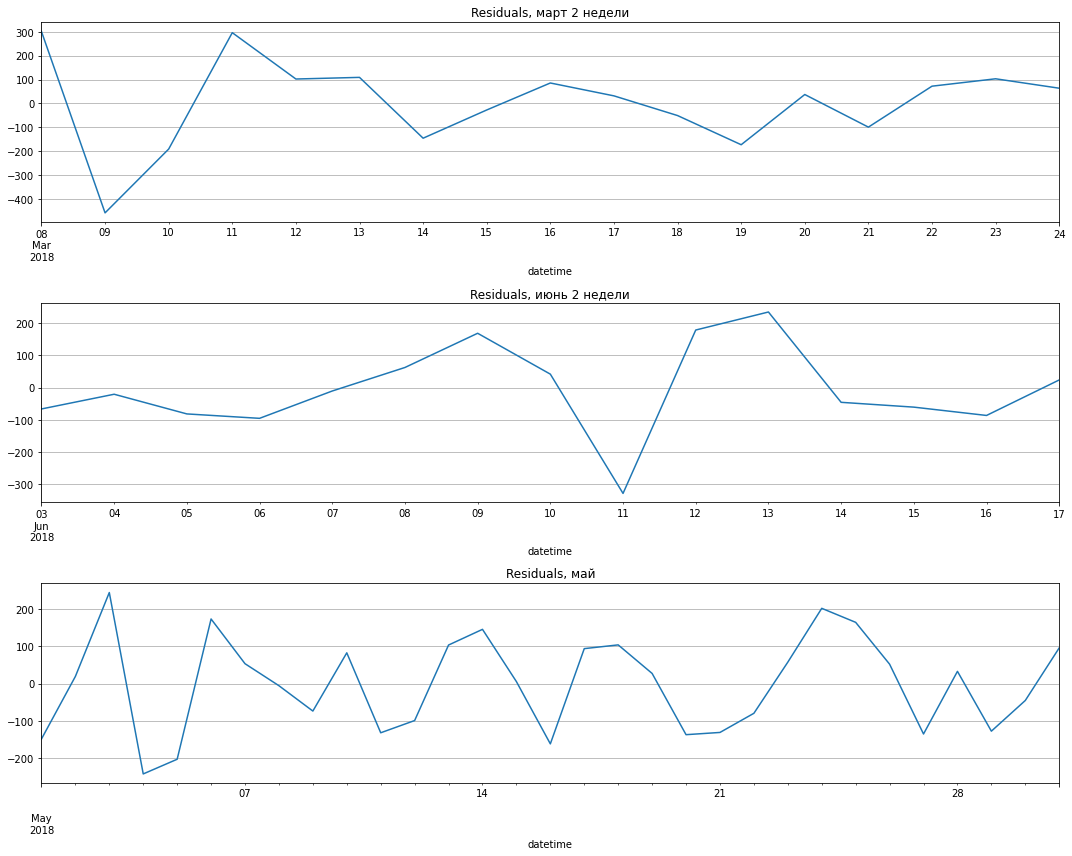

In [ ]:
plt.figure(figsize=(15, 12))

plt.subplot(311)
decomposed.resid['2018-03-08':'2018-03-24'].plot(ax=plt.gca(),grid=True);
plt.title('Residuals, март 2 недели')

plt.subplot(312)
decomposed.resid['2018-06-03':'2018-06-17'].plot(ax=plt.gca(),grid=True);
plt.title('Residuals, июнь 2 недели')


plt.subplot(313)
decomposed.resid['2018-05-01':'2018-05-31'].plot(ax=plt.gca(),grid=True);
plt.title('Residuals, май')

plt.tight_layout()


In [ ]:
# код ревьювера
from statsmodels.tsa.stattools import adfuller

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()

ts = taxi['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')


Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


Применим тест Дики-Фуллера.

In [ ]:
ts_dh = data_hour['num_orders']
st_test = adfuller(ts_dh, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


На тесте говорит, что ряд стационарный.
Теперь создадим признаки. Удалим пропуски.


In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['week'] = data.index.dayofweek
    data['day'] = data.index.day
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['roling_mean'] =  data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
make_features(data_hour, 100, 7)

In [ ]:
data_hour = data_hour.dropna()

Как определить количество необходимых "lag-ов". Потестила на 20, дает много RMSE, на 80 - тоже. На 100 - укладывается в значение в задании проекта.

In [ ]:
data_hour.head()

,num_orders,week,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,roling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,0,5,4,51.0,32.0,176.0,86.0,68.0,83.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,81.571429
2018-03-05 05:00:00,16,0,5,5,34.0,51.0,32.0,176.0,86.0,68.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,75.714286
2018-03-05 06:00:00,3,0,5,6,16.0,34.0,51.0,32.0,176.0,86.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,66.142857
2018-03-05 07:00:00,14,0,5,7,3.0,16.0,34.0,51.0,32.0,176.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,56.857143
2018-03-05 08:00:00,31,0,5,8,14.0,3.0,16.0,34.0,51.0,32.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,46.571429


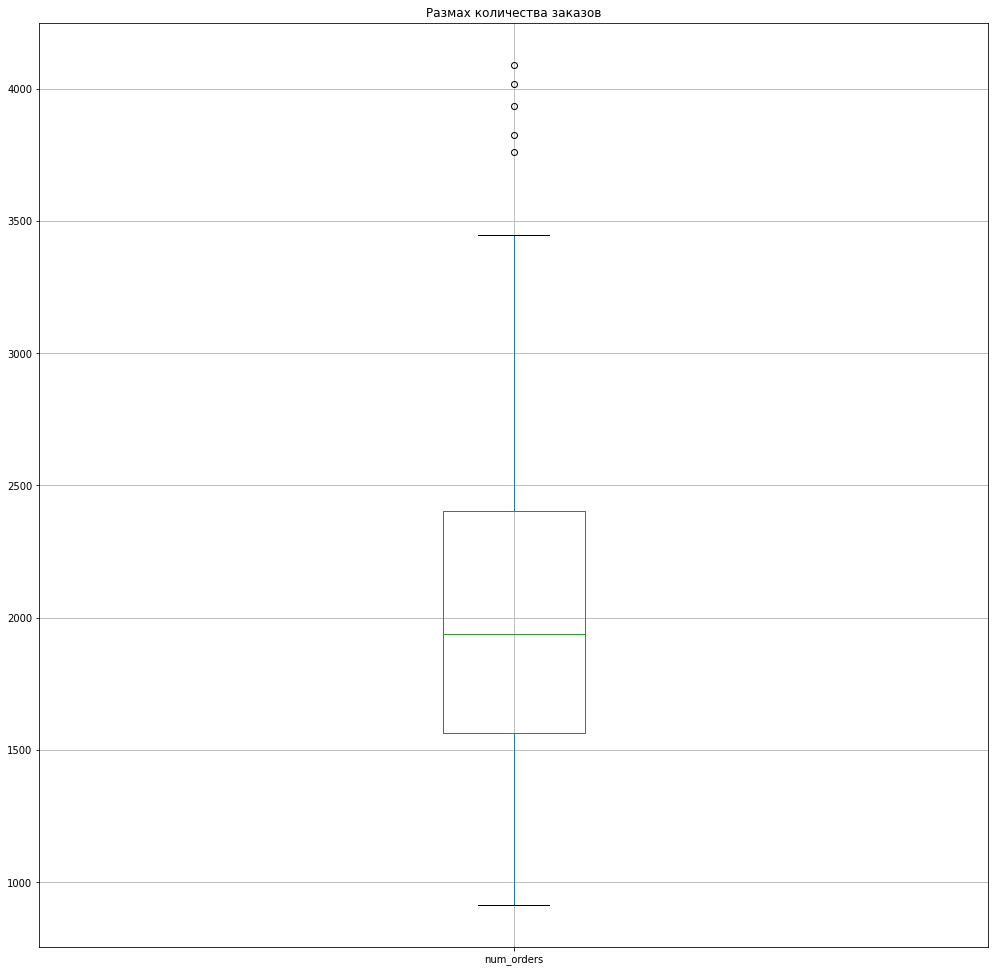

In [ ]:
d = data_hour[['num_orders']]
d = d.resample('1D').sum()
d['num_orders'].plot(kind='box', title='Размах количества заказов', figsize=(17,17), grid=True);

In [ ]:
print(d.loc[d['num_orders']>2500])

            num_orders
datetime              
2018-07-13        2523
2018-07-14        2502
2018-07-20        2607
2018-07-23        2706
2018-07-25        2515
2018-07-27        2923
2018-07-28        2725
2018-07-29        2596
2018-07-30        2774
2018-07-31        2526
2018-08-03        2679
2018-08-04        2569
2018-08-06        2794
2018-08-08        2669
2018-08-09        2630
2018-08-10        2916
2018-08-11        2763
2018-08-12        2706
2018-08-13        3356
2018-08-14        2868
2018-08-15        2943
2018-08-16        3087
2018-08-17        3244
2018-08-18        3033
2018-08-19        2801
2018-08-20        3826
2018-08-21        3077
2018-08-22        3035
2018-08-23        3244
2018-08-24        3352
2018-08-25        3448
2018-08-26        3315
2018-08-27        3936
2018-08-28        3357
2018-08-29        3762
2018-08-30        4090
2018-08-31        4018


Количество заказов растет, в августе эта тенденция сохраняется. Более того, конец августа - видно увеличение количества заказов такси. Последняя неделя характеризуется особенным ростом. Два последних дня августа - самые высокие показатели.

## Обучение

In [ ]:
train, test = train_test_split(data_hour, shuffle=False, test_size=0.1)

In [ ]:
train.shape, test.shape

((3884, 105), (432, 105))

In [ ]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-05 04:00:00 2018-08-13 23:00:00
2018-08-14 00:00:00 2018-08-31 23:00:00


In [ ]:
print("Среднее количество заказов за час", test['num_orders'].mean(),2)
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]

print("RMSE:", mean_squared_error(test, pred_previous)**0.5)

Среднее количество заказов за час 139.89814814814815 2
RMSE: 56.75739554880489


In [ ]:
targets_train = train['num_orders']
features_train = train.drop(['num_orders'],axis=1)

targets_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1)

In [ ]:
features_train.shape,targets_train.shape,features_test.shape,  targets_test.shape

((3884, 104), (3884,), (432, 104), (432,))

In [ ]:
features_train.isna().sum()

week           0
day            0
hour           0
lag_1          0
lag_2          0
              ..
lag_97         0
lag_98         0
lag_99         0
lag_100        0
roling_mean    0
Length: 104, dtype: int64

**Линейная регрессия**

In [ ]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5


RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [ ]:
%%time
params_LnR = {'fit_intercept':[True,False],
              'normalize':[True,False],
              'copy_X':[True, False]}


grid_LnR = GridSearchCV(LinearRegression(),
                        param_grid = params_LnR,
                        refit=False,
                        scoring=RMSE_score,
                        cv=TimeSeriesSplit(n_splits=3).split(features_train))



grid_LnR.fit(features_train, targets_train)


CPU times: user 6.33 s, sys: 19.4 s, total: 25.7 s
Wall time: 25.7 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f6dedfb7580>,
             estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             refit=False, scoring=make_scorer(RMSE, greater_is_better=False))

In [ ]:
print("RMSE на линейной регрессии:", abs(grid_LnR.best_score_))

RMSE на линейной регрессии: 24.388459064648117


In [ ]:
grid_LnR.best_params_

{'copy_X': True, 'fit_intercept': False, 'normalize': True}

**Случайный лес**

In [ ]:
%%time
params_RFR = {'n_estimators': range(5, 50, 5),
                     'max_depth': range(1, 6),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }


grid_RFR = GridSearchCV(RandomForestRegressor(),
                        param_grid = params_RFR,
                        scoring=RMSE_score,
                        cv = TimeSeriesSplit(n_splits=3),
                        n_jobs=-1,
                        verbose=10)

grid_RFR.fit(features_train, targets_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
[CV 1/3; 1/540] START max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=5
[CV 1/3; 1/540] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV 2/3; 1/540] START max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=5
[CV 2/3; 1/540] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV 3/3; 1/540] START max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=5
[CV 3/3; 1/540] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV 1/3; 2/540] START max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 1/3; 2/540] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV 2/3; 2/540] START max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 2/3; 2/540] END max_depth=1, min_sampl

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 8, 2),
                         'n_estimators': range(5, 50, 5)},
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=10)

In [ ]:
print("RMSE на случайном лесе:", abs(grid_RFR.best_score_))

RMSE на случайном лесе: 26.260595402271615


**Модель LGB**

In [ ]:
%%time
model_LGB = LGBMRegressor()
params = {
        'boosting_type' : ['gbdt'],
        'n_estimators' : range(5, 50, 5),
        'max_depth' : range(3, 5),
        'verbose' : [100],
        'random_state' : [123],
        'num_leaves' : [100]}

grid_LGB = GridSearchCV(estimator=model_LGB,
                        param_grid=params,
                        cv=TimeSeriesSplit(n_splits=3).split(features_train),
                        n_jobs=-1,
                        scoring=RMSE_score)

CPU times: user 108 µs, sys: 2 µs, total: 110 µs
Wall time: 115 µs


In [ ]:
grid_LGB.fit(features_train, targets_train)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.002773
[LightGBM] [Debug] init for col-wise cost 0.009215 seconds, init for row-wise cost 0.175151 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11699
[LightGBM] [Info] Number of data points in the train set: 971, number of used features: 104
[LightGBM] [Info] Start training from score 57.813594
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.002302
[LightGBM] [Debug] init for col-wise cost 0.014022 seconds, init for row-wise co

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f6dee112cf0>,
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'], 'max_depth': range(3, 5),
                         'n_estimators': range(5, 50, 5), 'num_leaves': [100],
                         'random_state': [123], 'verbose': [100]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [ ]:
print("RMSE на LGBMRegressor:", abs(grid_LGB.best_score_))

RMSE на LGBMRegressor: 25.036587218088986


Рассмотрены 3 модели:
- Случайный лес
- Линейная регрессия
- LightGBM

Получили следующие показатели:<br/>
- RMSE на линейной регрессии: 24.854498638545778 (24.389005045961017)
- RMSE на случайном лесе: 26.10222093800333
- RMSE на LGBMRegressor: 24.71112944663149 (25.036587218088986)


Лучший результат дала модель LGBMRegressor. Ее и протестируем.

<div class="alert alert-info">
Теперь лучший результат дала линейная регрессия. Протестируем ее.
</div>

## Тестирование

In [ ]:
params_LnR_best = grid_LnR.best_params_

model_LnR = LinearRegression(**params_LnR_best)
model_LnR.fit(features_train, targets_train)

predict_LnR= model_LnR.predict(features_test)

RMSE_LnR = mean_squared_error(targets_test, predict_LnR)**0.5
print("RMSE на Линейной регрессии: ", RMSE_LnR)


RMSE на Линейной регрессии:  40.086309822863086


In [ ]:
def plot_models_predict(target_test, predict):

    rmse= mean_squared_error(target_test, predict)**0.5

    plt.figure(figsize=(10, 10))

    pd.Series(target_test).hist(bins=20,  edgecolor = "black",alpha=0.5)
    pd.Series(predict).hist(bins=20, edgecolor = "black",alpha=0.5 )
    plt.text(50,50,'RMSE={:.2f}'.format(rmse))
    plt.legend(['Истинные значения', 'Предсказанные значения'])
    plt.title('График распределения предсказанных и истинных значениий')
    plt.xlabel('Предсказанные / Истинные значения')
    plt.ylabel('Количество')


    plt.figure(figsize=(10, 10))
    plt.plot(target_test, predict,'o', alpha=0.6)
    plt.xlim(0,500)
    plt.ylim(0,500)
    plt.plot([0,500],[0,500],'--y', linewidth=2)
    plt.title('График отношения предсказанных значений к истинным значениям')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.grid(True)

    plt.show()

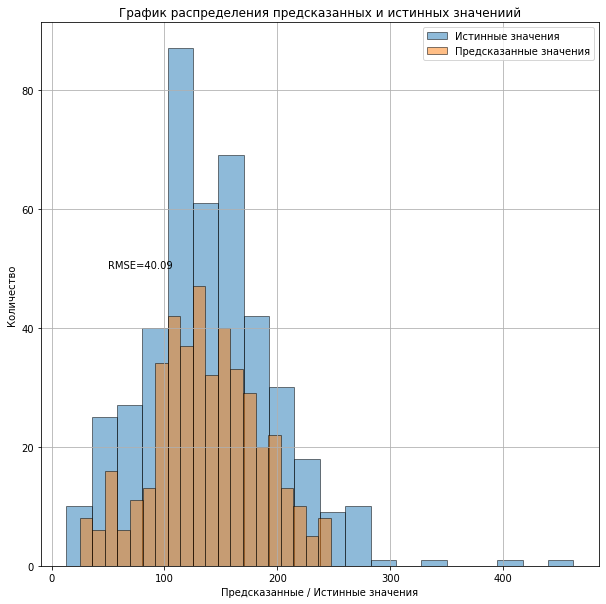

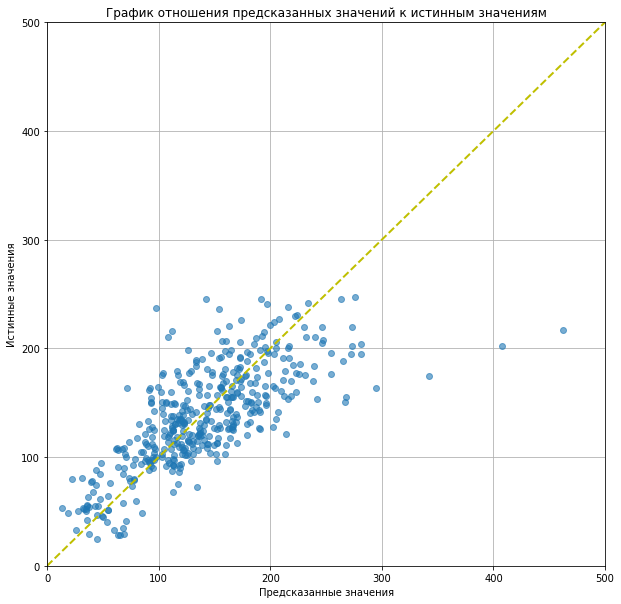

In [ ]:
plot_models_predict(targets_test, predict_LnR)

**Вывод:**
    
В ходе работы над проектом выполнено следующее:
- данные загружены,
- выполнена предобработка,
- подготовлен новый датафрейм с новыми временными интервалами и признаками,
- данные проанализированы,
- выполнен подбор лучших гиперпараметров для трех моделей (Линейная регрессия, случайный лес,  LGB),
- модели обучены,
- рассчитан RMSE,
- выбрана лучшая модель,
- модель протестирована.

Исходный датасет содержит 26496 записей - данные о заказах такси с интервалом в 10 минут. Данные за период с марта по август 2018 года.

Анализ данных показал следующее:
- количество заказов в день в среднем колеблется от 54 до 107
- наблюдается рост количества заказов к лету.
- наименьшая загруженность в утренние часы - 5 часов, с 00.00 начинается спад
- пик заказов приходится на 11-12 часов, 21 час, 0 часов
- в течение дня имеем тенденцию роста
- по дням недели пик заказов приходится на понедельник, пятницу.
- меньше всего заказов во вторник и воскресенье, а во вторник меньше чем в воскресенье. Со вторника по пятницу количество заказов постепенно нарастает.
- в течение всего рассматриваемого периода по месяцам количество заказов стабильно растет, в августе эта тенденция сохраняется.
- конец августа - видно увеличение количества заказов такси. Последняя неделя характеризуется особенным ростом. Два последних дня августа - самые высокие показатели.

Лучший показатель из трех рассмотренных моделей дала модель LGB. Конечно время работы этой модели достаточно длительное. <br/>
Результат RMSE:
- на тренировочной выборке: 24.71112944663149
- на тестовой выборке:  40.633214026907

На графике наглядно видно степень совпадения исходных и предсказанных значений.


<div class="alert alert-info">
В качестве лучшей выбрана модель - линейная регрессия, которая дала самый лучшие показатель RMSE - 24.389005045961017. Проверена на тестовой выборке, результат 40.086309822863086.
</div>

<div class="alert alert-info">
Модель не предсказывает значения больше 250. Они выглядели как выбросы, учиться не начем, это данные августовские в основном, ряд закончился, поэтому (наверное) модель и ошибается.
</div>